# Classification example:  'Apple','Banana','Watermelon'

# MLP

In [1]:
import json
classnames = ['Apple','Banana','Watermelon']  
import os
import numpy as np
imagepaths, labels=[],[]
for dirname, _, filenames in os.walk('./dataset/Example_fruit/Train'):
    fruitname = dirname.split("\\")[-1]
    label = -1
    if fruitname=='Apple':
        label = 0
    elif fruitname=='Banana':
        label = 1
    elif fruitname=='Watermelon':
        label = 2
    for filename in filenames:
        imagepaths.append(os.path.join(dirname, filename))
        labels.append(label)
    
print(imagepaths[0])
print(labels)
print(len(imagepaths))
print(len(labels))

data={}
data['imagepaths']=imagepaths
data['labels'] = labels
with open('./dataset/database/data_fruit.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)
    

./dataset/Example_fruit/Train\Apple\0_100.jpg
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
139
139


In [2]:
import torch
import numpy as np
import PIL.Image as Image
import torchvision.transforms.functional as FT
from torchvision import transforms
import json

mytransform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        ])
def my_collate(batch):
    data, target = list(), list()
    for b in batch:
        data.append(b[0])
        target.append(b[1])
    data = torch.stack(data,dim=0)
    target = torch.stack(target,dim=0)
    return data, target

class MyDataset_Fruits(torch.utils.data.Dataset):
    '''
    load the dataset
    '''
    def __init__(self,transforms):
        with open('./dataset/database/data_fruit.json') as jsonfile:
            data_load = json.load(jsonfile)
        self.imList = data_load['imagepaths']
        self.labelList = data_load['labels']
        self.transforms=transforms
        print('number of total data:{}'.format(len(self.imList)))
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
    
        
        # Convert PIL label image to torch.Tensor
        image = self.transforms(image)
        label = torch.tensor(label)
        return image, label

if __name__ == "__main__":
    mytransform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor()
            ])
    mydataset = MyDataset_Fruits(transforms=mytransform)
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=10, num_workers=0,  collate_fn = my_collate)
    for data in mydata_loader:
        print(data[0].size())
        print(data[1].size())
        break    


number of total data:139
torch.Size([10, 3, 28, 28])
torch.Size([10])


In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np

# 步驟0. 是否使用CUDA 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
device = torch.device("cpu")
print(device)
# 步驟1. data loader處理 
mytransform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor()
            ])

dataset_train = MyDataset_Fruits(transforms=mytransform)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=13, num_workers=0, shuffle=False, collate_fn = my_collate)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, num_workers=0, shuffle=True, collate_fn = my_collate)

# 步驟2. 模型宣告
class MLP(nn.Module):
    def __init__(self, n_class=3):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(3*28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128,n_class)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,3*28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.droput(x)
        x = self.fc4(x)
        return x
    
    
model_mlp = MLP(n_class=3)
print(model_mlp)
model_mlp = model_mlp.to(device)

cpu
number of total data:139
MLP(
  (fc1): Linear(in_features=2352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [4]:
    
# initialize the MLP
model_mlp = MLP(n_class=3).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.01)


In [5]:
# 步驟5. 模型開始訓練
total_epoch=300
plt_loss_train=[]
for epoch in range(total_epoch):
    # train
    model_mlp.train()
    train_loss_mlp = 0
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data = torch.squeeze(data)
        data, target = data.to(device), target.to(device)
        # MLP
#         print(target)
        optimizer_mlp.zero_grad()
        output_mlp = model_mlp(data)
        loss_mlp = loss(output_mlp,target)  
        train_loss_mlp += loss_mlp
        loss_mlp.backward()
        optimizer_mlp.step()
    train_loss_mlp /= len(dataloader_train.dataset)
    plt_loss_train.append(train_loss_mlp)
   
    if epoch % 10 ==0:
        print('MLP[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_mlp))
print('MLP[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_mlp))
print('training done.')

MLP[epoch: 1/300], Average loss (Train):0.1702181995
MLP[epoch: 11/300], Average loss (Train):0.0000000928
MLP[epoch: 21/300], Average loss (Train):0.0186484624
MLP[epoch: 31/300], Average loss (Train):0.0000238658
MLP[epoch: 41/300], Average loss (Train):0.0000618451
MLP[epoch: 51/300], Average loss (Train):0.0000000200
MLP[epoch: 61/300], Average loss (Train):0.0000000155
MLP[epoch: 71/300], Average loss (Train):0.0000000275
MLP[epoch: 81/300], Average loss (Train):0.0049597411
MLP[epoch: 91/300], Average loss (Train):0.0000074242
MLP[epoch: 101/300], Average loss (Train):0.0000028153
MLP[epoch: 111/300], Average loss (Train):0.0000001754
MLP[epoch: 121/300], Average loss (Train):0.0000001162
MLP[epoch: 131/300], Average loss (Train):0.0000007466
MLP[epoch: 141/300], Average loss (Train):0.0000002773
MLP[epoch: 151/300], Average loss (Train):0.0000000174
MLP[epoch: 161/300], Average loss (Train):0.0000001591
MLP[epoch: 171/300], Average loss (Train):0.0000001445
MLP[epoch: 181/300], 

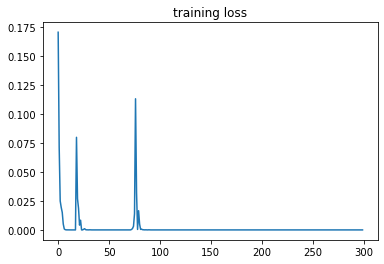

In [6]:
plt.plot(plt_loss_train)
plt.title('training loss')
plt.show()

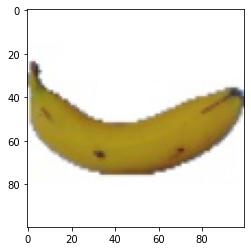

probability for Apple: 0.0000%
probability for Banana: 100.0000%
probability for Watermelon: 0.0000%


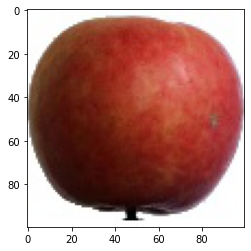

probability for Apple: 100.0000%
probability for Banana: 0.0000%
probability for Watermelon: 0.0000%


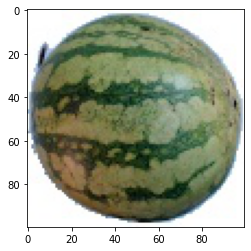

probability for Apple: 99.9975%
probability for Banana: 0.0025%
probability for Watermelon: 0.0000%


In [7]:

mytransform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor()
        ])
model_mlp.eval()  

#114_100.jpg#
#123_100.jpg#
#r_176_100.jpg#
image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
              './dataset/Example_fruit/Test/123_100.jpg',
              './dataset/Example_fruit/Test/r_176_100.jpg']
for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')

    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)

    with torch.no_grad():
        output_mlp = model_mlp(image)
    output_mlp= F.softmax(output_mlp)

    list_class = ['Apple','Banana','Watermelon']
    for i, tmp_out in enumerate(output_mlp[0]):
        print('probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))


# CNN training

In [8]:

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self, n_class=3):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(3, 32, 5, 2),
            ConvM(32, 64, 5, 2),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, n_class)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

# initialize the ConvNet
model_cnn = ConvNet(n_class=3).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)



In [11]:
# 步驟5. CNN模型開始訓練
total_epoch=500
plt_loss_train_cnn=[]
for epoch in range(total_epoch):
    # train
    model_cnn.train()
    train_loss_cnn = 0
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP
#         print(target)
        optimizer_cnn.zero_grad()
        output_cnn = model_cnn(data)
        loss_cnn = loss(output_cnn,target)  
        train_loss_cnn += loss_cnn
        loss_cnn.backward()
        optimizer_cnn.step()
    train_loss_cnn /= len(dataloader_train.dataset)
    plt_loss_train_cnn.append(train_loss_cnn)
   
    if epoch % 10 ==0:
        print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('training done.')

CNN[epoch: 1/500], Average loss (Train):0.0000671497
CNN[epoch: 11/500], Average loss (Train):0.0000596506
CNN[epoch: 21/500], Average loss (Train):0.0000528787
CNN[epoch: 31/500], Average loss (Train):0.0000429575
CNN[epoch: 41/500], Average loss (Train):0.0000208726
CNN[epoch: 51/500], Average loss (Train):0.0000134699
CNN[epoch: 61/500], Average loss (Train):0.0000757391
CNN[epoch: 71/500], Average loss (Train):0.0000373382
CNN[epoch: 81/500], Average loss (Train):0.0014014244
CNN[epoch: 91/500], Average loss (Train):0.0000275765
CNN[epoch: 101/500], Average loss (Train):0.0000136955
CNN[epoch: 111/500], Average loss (Train):0.0000113480
CNN[epoch: 121/500], Average loss (Train):0.0000562481
CNN[epoch: 131/500], Average loss (Train):0.0000999278
CNN[epoch: 141/500], Average loss (Train):0.0000321428
CNN[epoch: 151/500], Average loss (Train):0.0000366957
CNN[epoch: 161/500], Average loss (Train):0.0000168630
CNN[epoch: 171/500], Average loss (Train):0.0000677511
CNN[epoch: 181/500], 

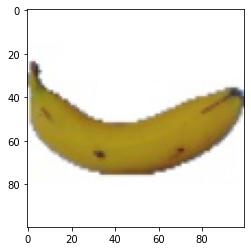

torch.Size([3, 28, 28])
MLP: probability for Apple: 0.0000%
MLP: probability for Banana: 100.0000%
MLP: probability for Watermelon: 0.0000%
**************************************************
CNN: probability for Apple: 33.8236%
CNN: probability for Banana: 27.5399%
CNN: probability for Watermelon: 38.6365%


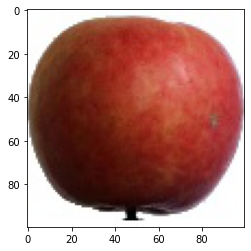

torch.Size([3, 28, 28])
MLP: probability for Apple: 100.0000%
MLP: probability for Banana: 0.0000%
MLP: probability for Watermelon: 0.0000%
**************************************************
CNN: probability for Apple: 34.1511%
CNN: probability for Banana: 22.0886%
CNN: probability for Watermelon: 43.7603%


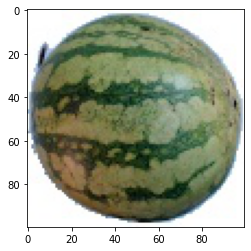

torch.Size([3, 28, 28])
MLP: probability for Apple: 99.9975%
MLP: probability for Banana: 0.0025%
MLP: probability for Watermelon: 0.0000%
**************************************************
CNN: probability for Apple: 16.7053%
CNN: probability for Banana: 18.7685%
CNN: probability for Watermelon: 64.5262%


In [15]:

mytransform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor()
        ])
model_mlp.eval()  

#114_100.jpg#
#123_100.jpg#
#r_176_100.jpg#
image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
              './dataset/Example_fruit/Test/123_100.jpg',
              './dataset/Example_fruit/Test/r_176_100.jpg']
for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)
    print(image.shape)
    with torch.no_grad():
        output_mlp = model_mlp(torch.squeeze(image))
        output_cnn = model_cnn(torch.unsqueeze(image,dim=0).to(device))
    output_mlp= F.softmax(output_mlp)
    output_cnn= F.softmax(output_cnn)

    list_class = ['Apple','Banana','Watermelon']
    for i, tmp_out in enumerate(output_mlp[0]):
        print('MLP: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))
    print('*'*50)    
    for i, tmp_out in enumerate(output_cnn[0]):
        print('CNN: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))